<a href="https://www.kaggle.com/code/akanshakhandelwal08/may-tableground-xgboost-gridsearchcv?scriptVersionId=95745994" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-may-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2022/train.csv
/kaggle/input/tabular-playground-series-may-2022/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Reading and understanding data


In [3]:

data = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/train.csv')


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-null  float64
 21  f_20    90

In [5]:
data['f_27'].value_counts()

BBBBBBCJBC    12
BCBBBBCLBC    12
BBBBBBDPCB    10
BBBBBBDKBC    10
ADBBBACQBC    10
              ..
BFAFAADTCE     1
BBBDAACOAE     1
BBABAACGBB     1
BFAABAGSDB     1
BCAACADSCE     1
Name: f_27, Length: 741354, dtype: int64

Dropping the column 

In [6]:
data.isnull().sum()

id        0
f_00      0
f_01      0
f_02      0
f_03      0
f_04      0
f_05      0
f_06      0
f_07      0
f_08      0
f_09      0
f_10      0
f_11      0
f_12      0
f_13      0
f_14      0
f_15      0
f_16      0
f_17      0
f_18      0
f_19      0
f_20      0
f_21      0
f_22      0
f_23      0
f_24      0
f_25      0
f_26      0
f_27      0
f_28      0
f_29      0
f_30      0
target    0
dtype: int64

There are no null values in the dataset

## EDA

In [7]:
def numerical_plot(data,colname):
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plt.title("TARGET by "+ colname)
    sns.kdeplot(data.loc[(data['target']==0),colname], color="g", label="Machine State 0",legend=True)
    sns.kdeplot(data.loc[(data['target']==1),colname],color="r", label="Machine State 1",legend=True) 
    plt.legend()
    plt.subplot(1,2,2)
    plt.title("BOXPLOT TARGET by "+ colname)
    sns.boxplot(y=colname, data=data, x="target")
    plt.show()
    
def corr_plot(data, reduced_col):
    k = len(reduced_col) #number of variables for heatmap
    cols = data.loc[:,reduced_col].corr()['target'].index
    cm = data[cols].corr()
    mask = np.triu(np.ones_like(cm, dtype=bool))
    cmap=sns.diverging_palette(20, 220, n=200)
    plt.figure(figsize=(14,14))
    sns.heatmap(cm,cmap = cmap,mask=mask)
    plt.show()

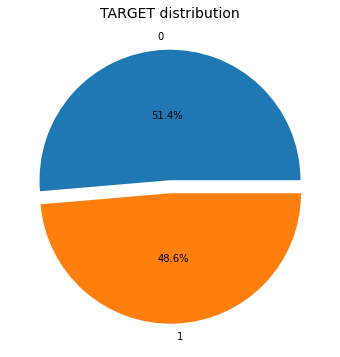

In [8]:
target = data["target"].value_counts(normalize=True)
pie, ax = plt.subplots(figsize=[10,6])
labels = target.keys()
plt.pie(x=target, autopct="%.1f%%", labels=labels, pctdistance=0.5,explode=[0.05]*2)
plt.title("TARGET distribution", fontsize=14);

In [9]:
numeric_cols = data.select_dtypes(include=np.number).columns.tolist()

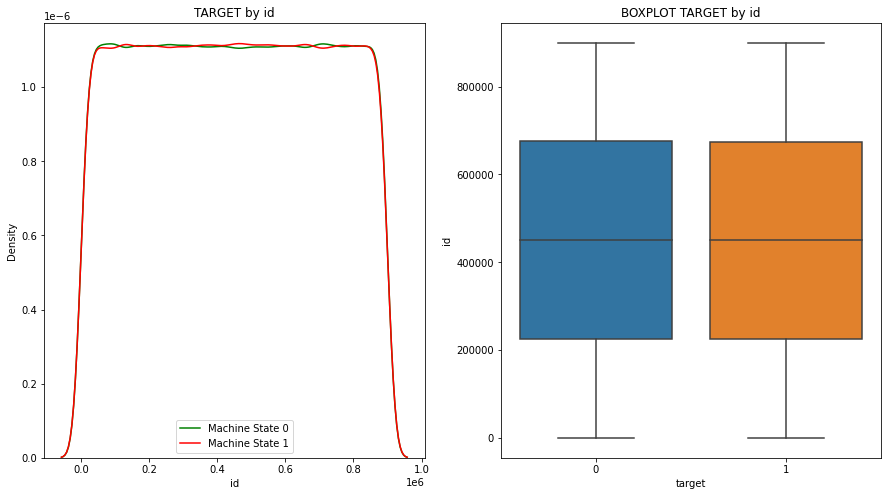

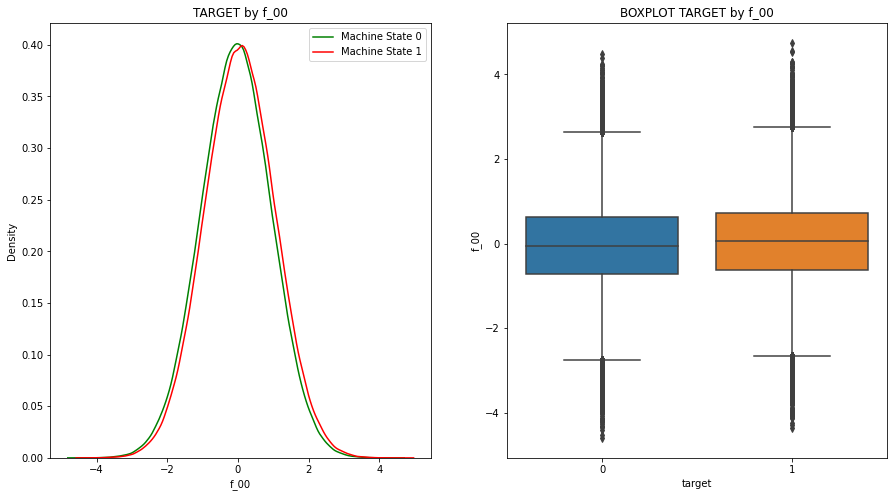

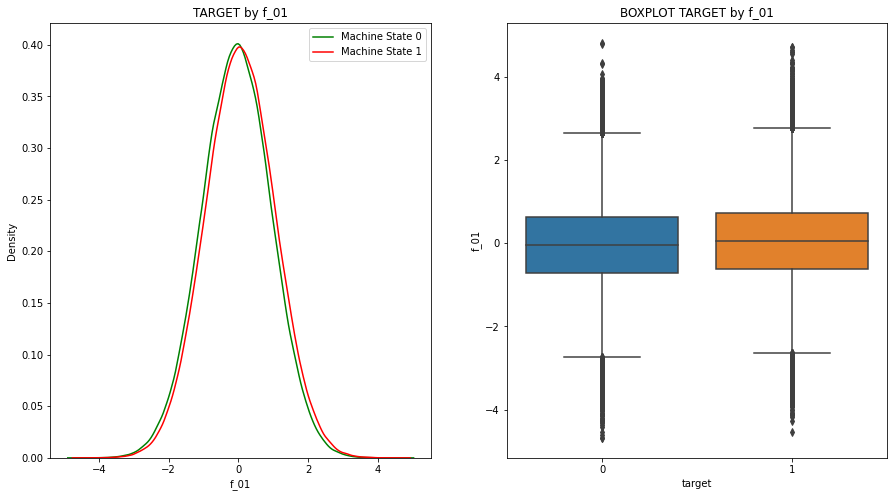

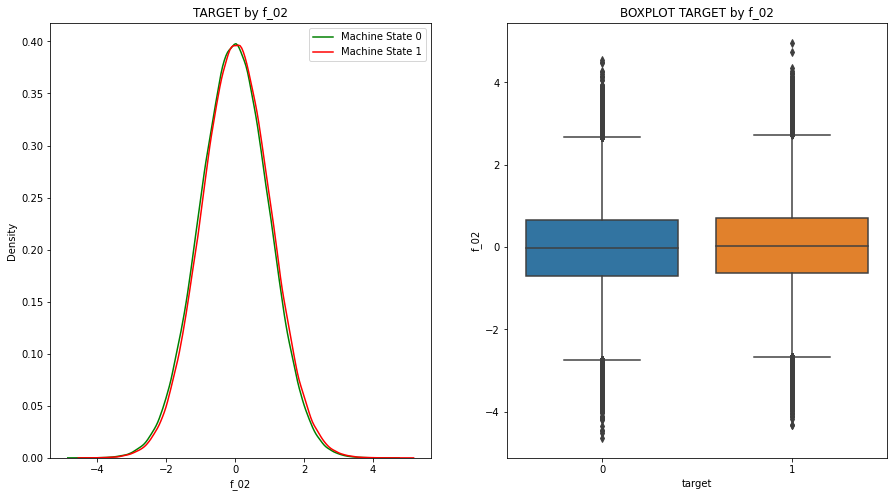

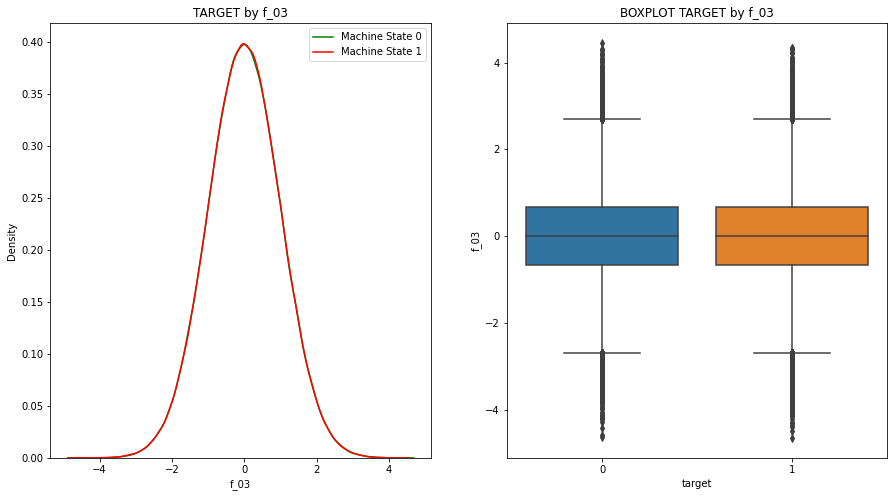

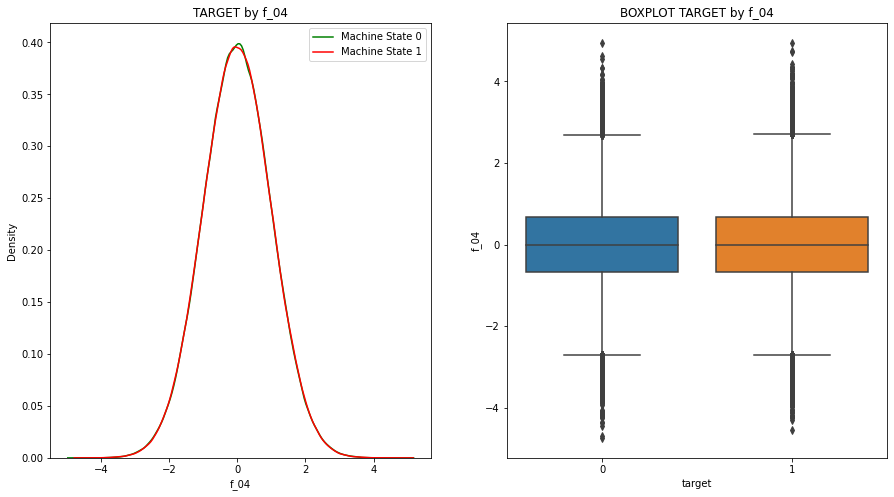

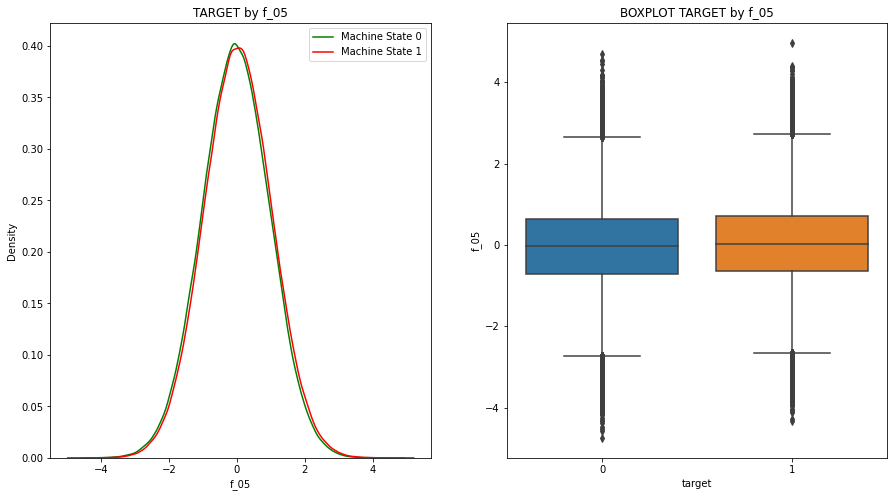

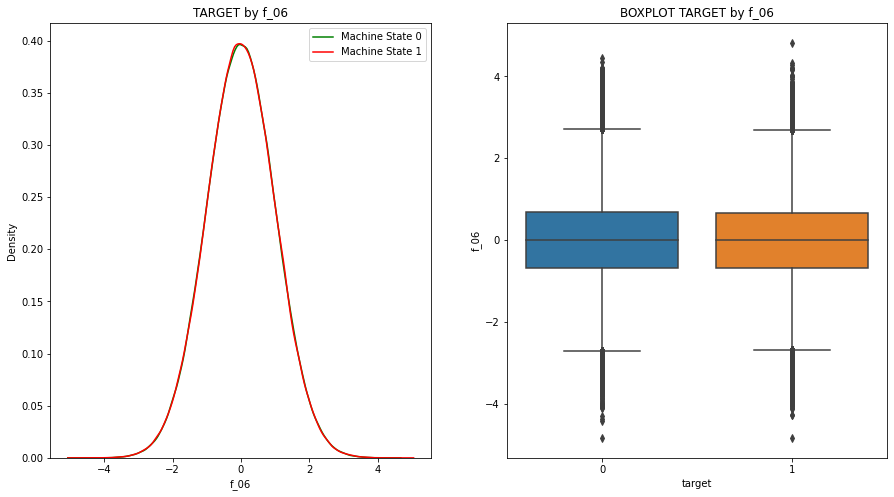

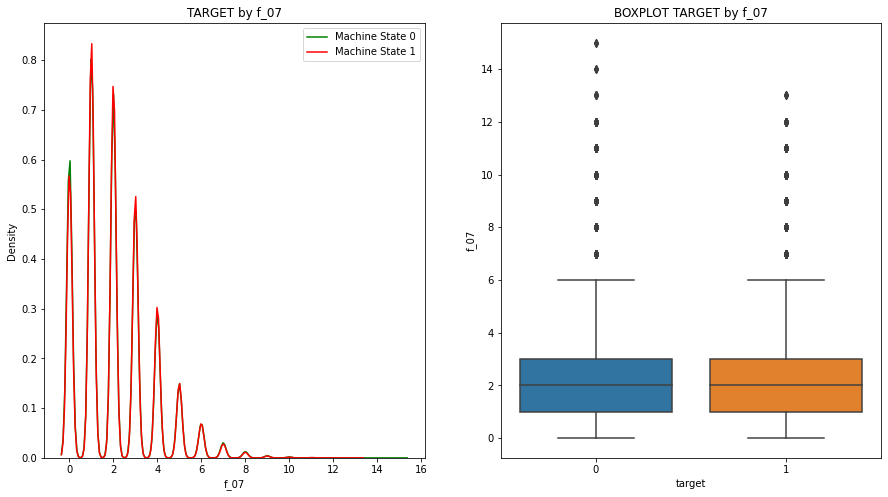

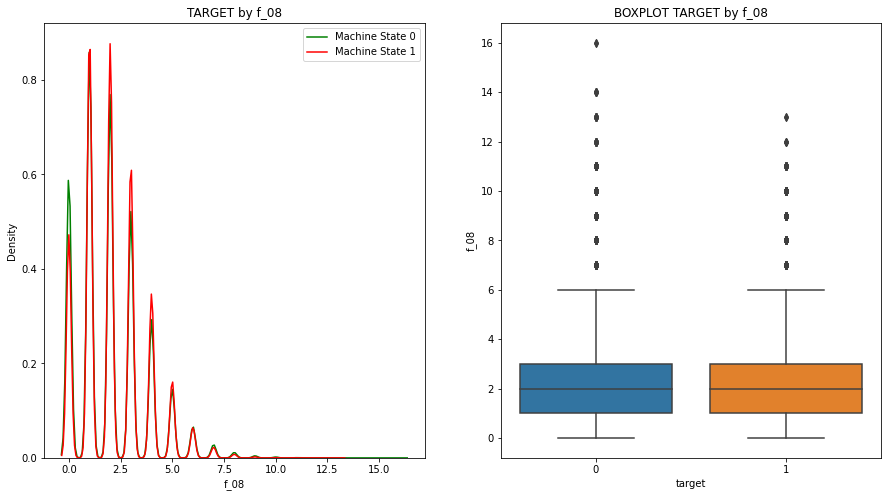

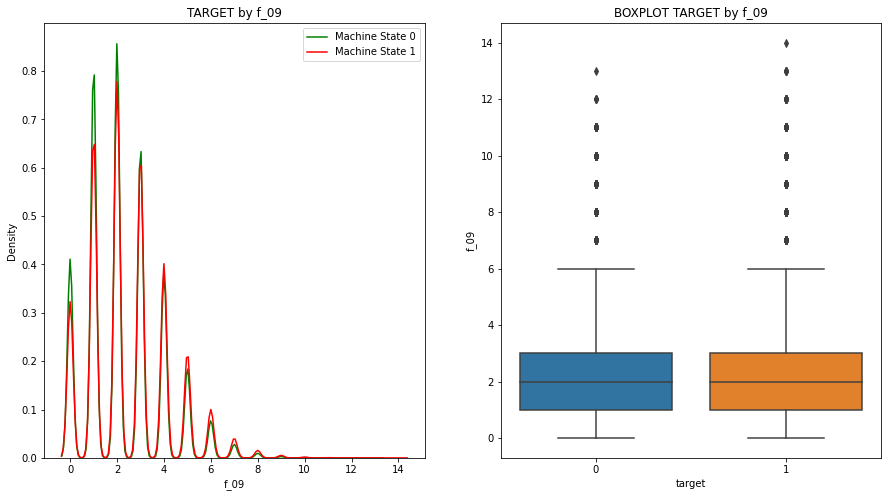

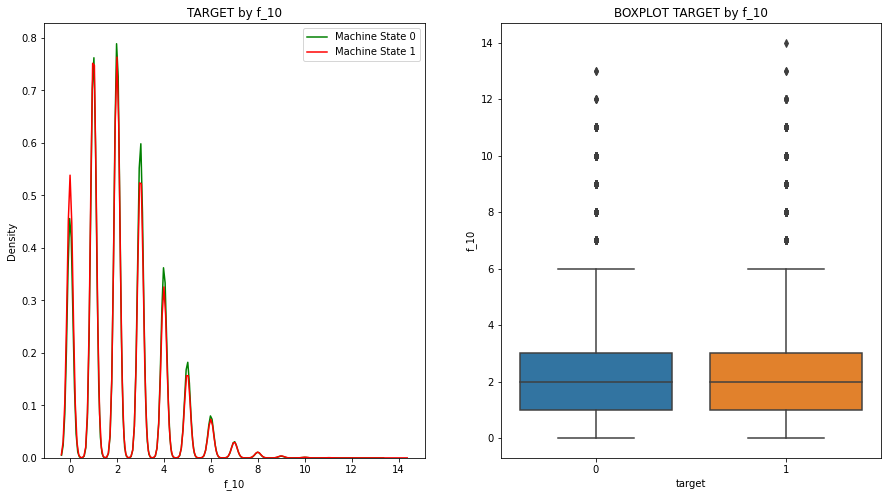

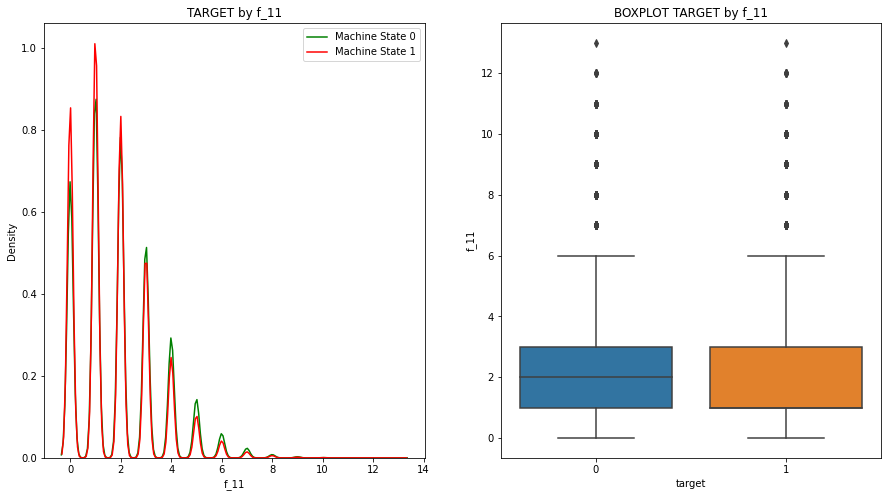

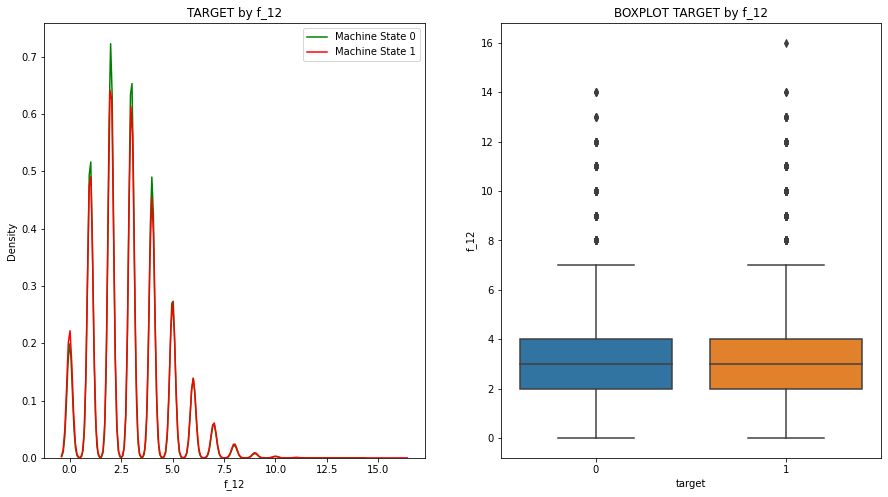

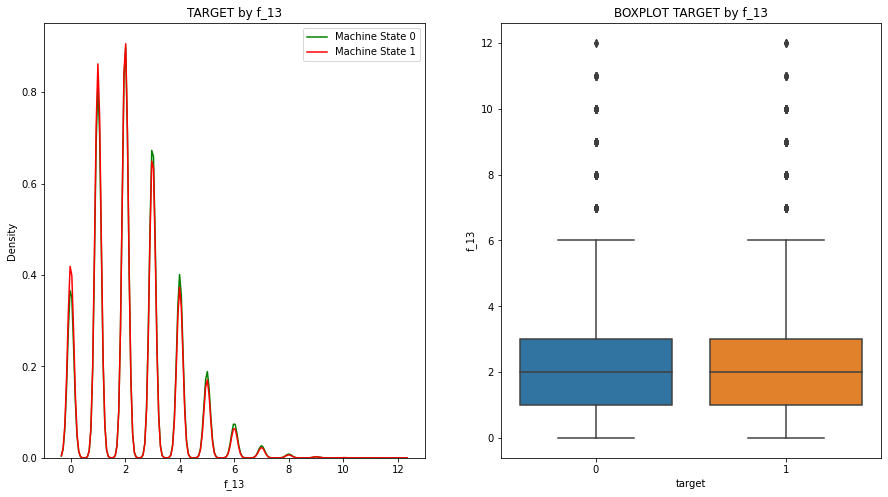

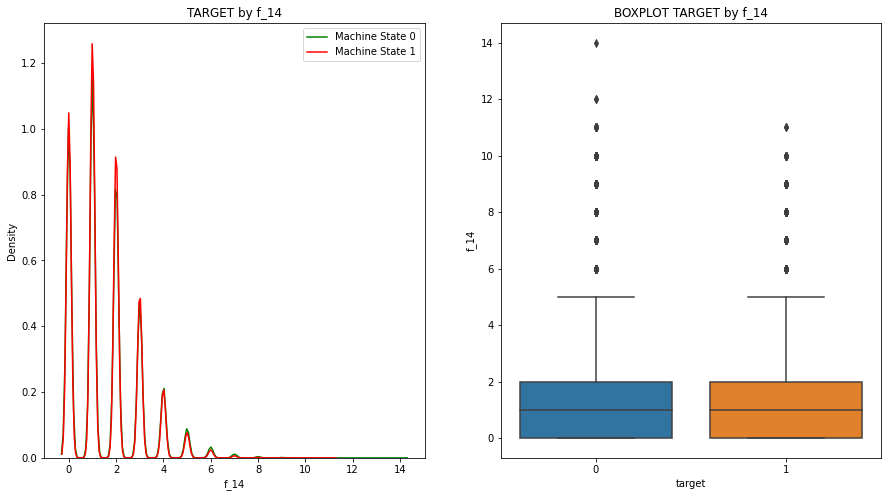

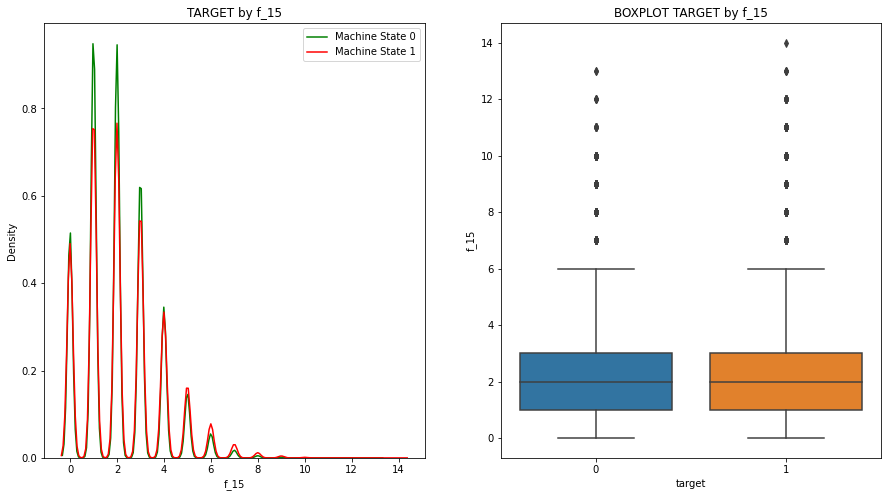

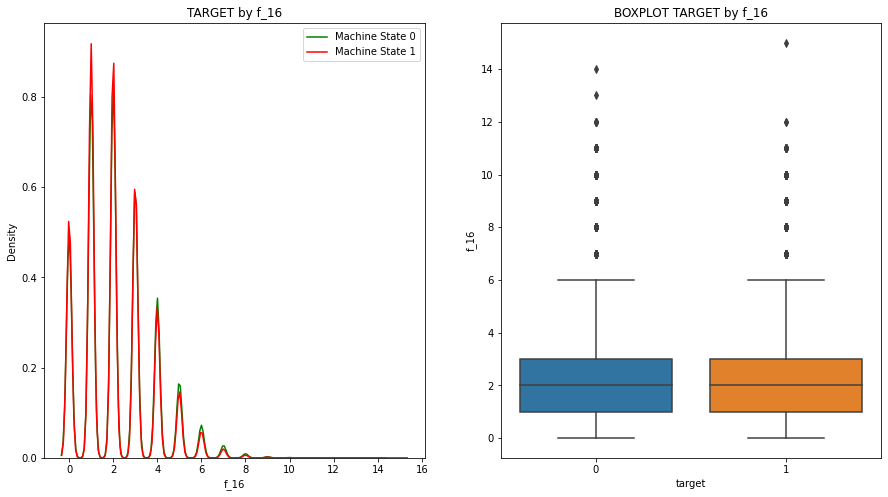

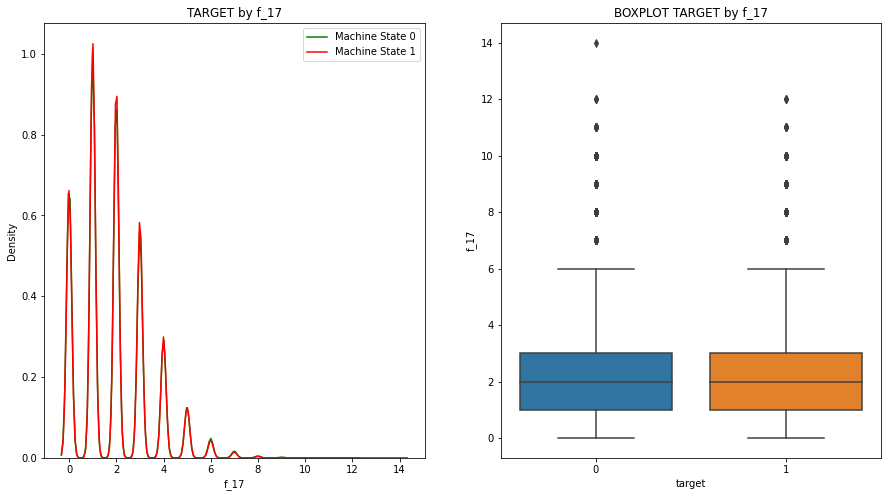

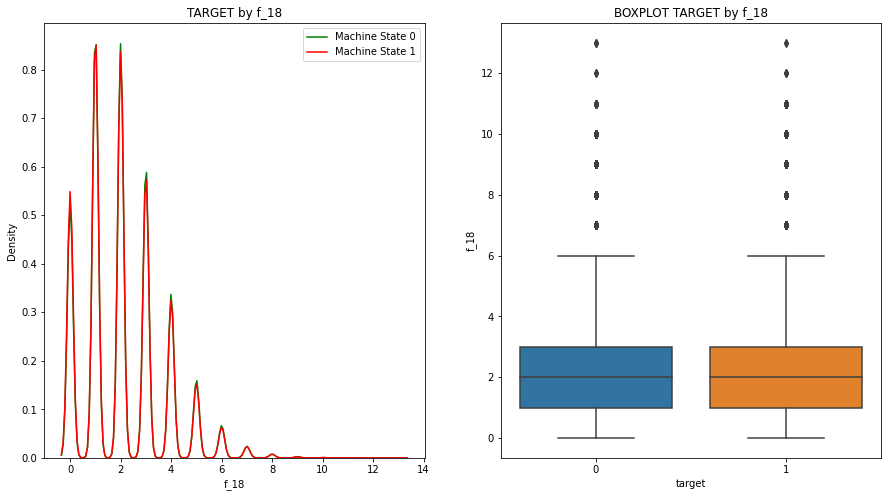

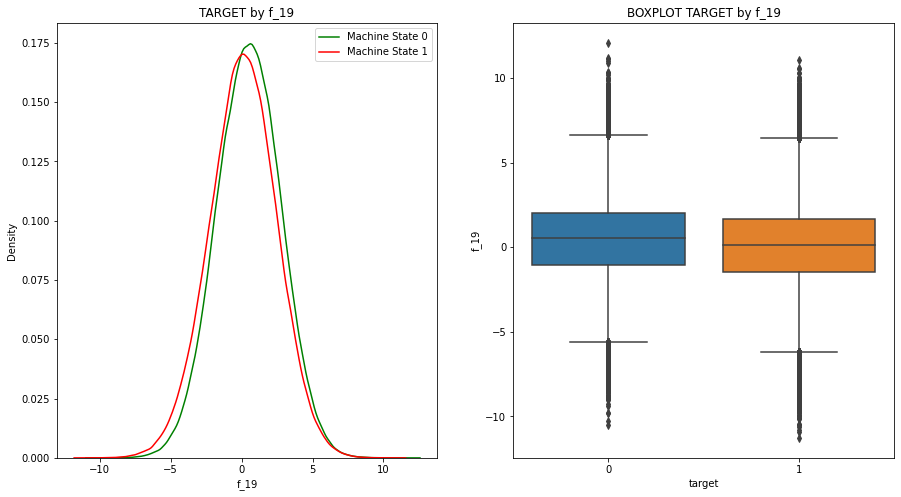

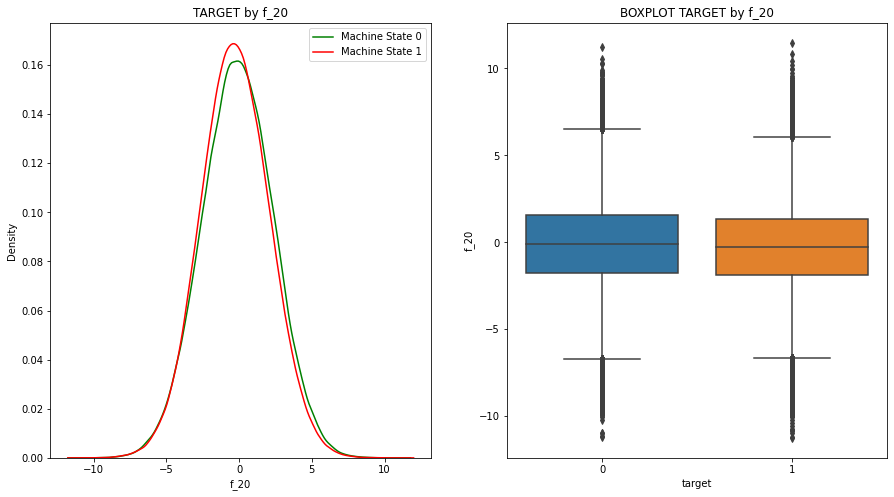

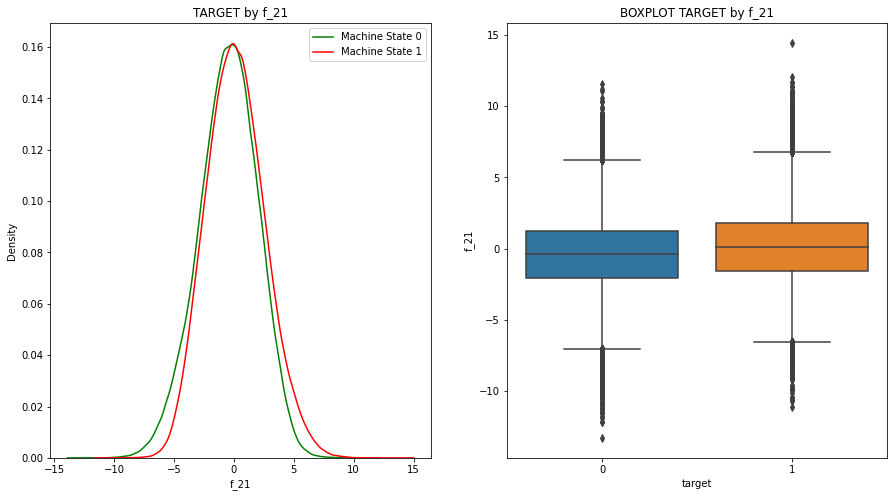

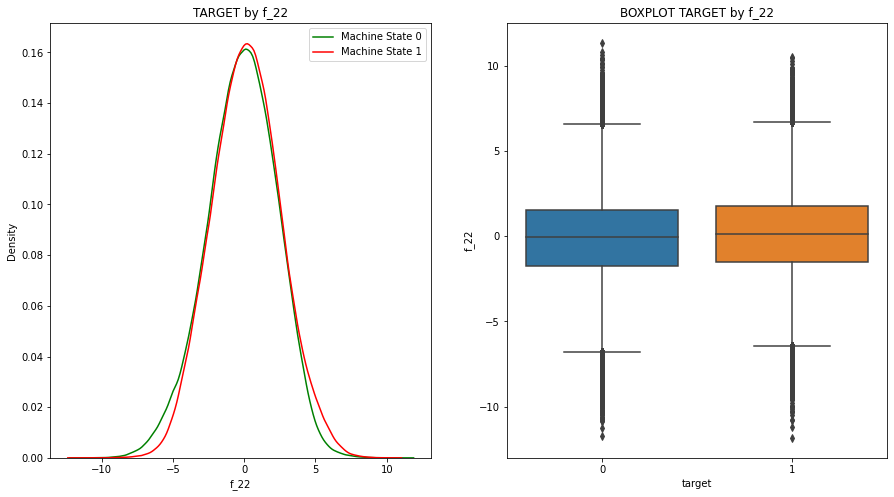

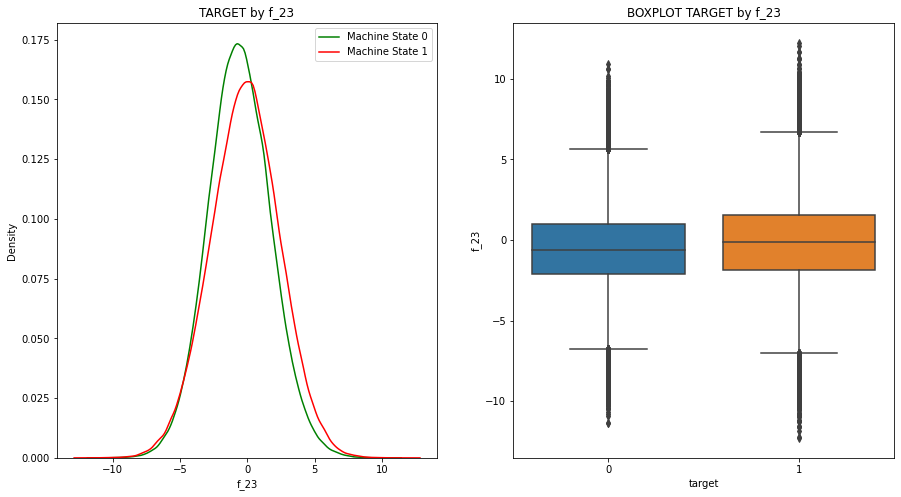

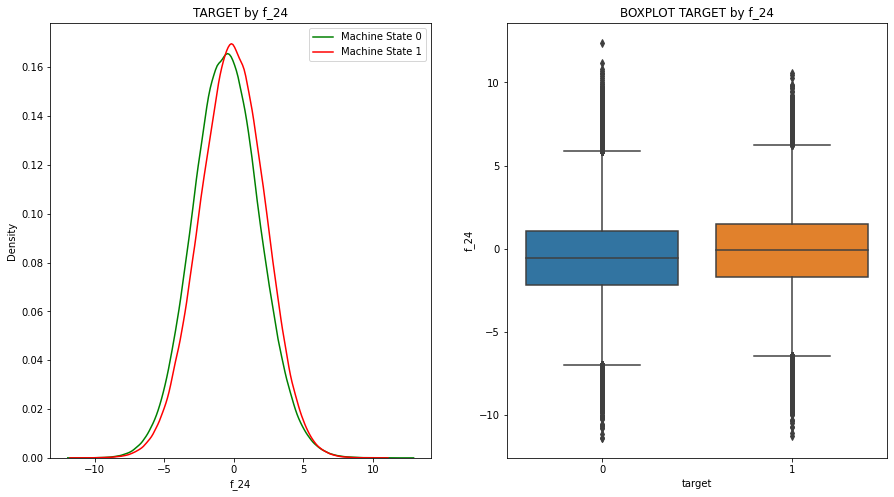

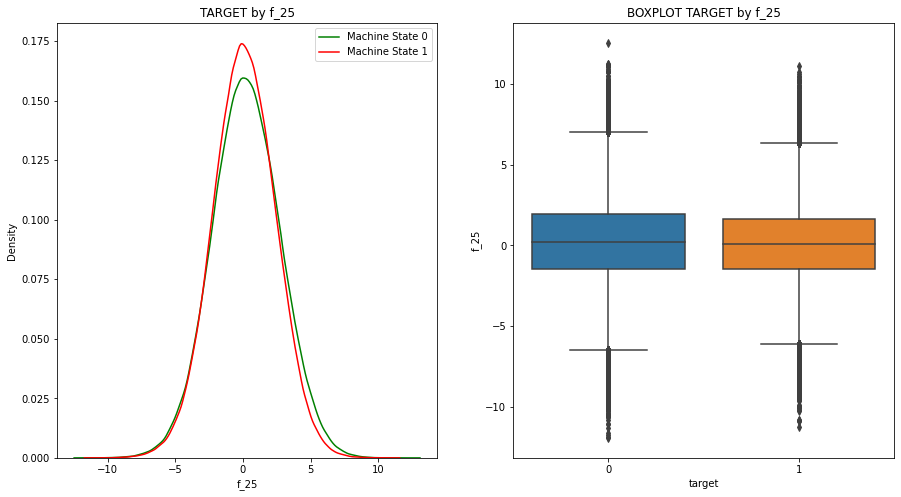

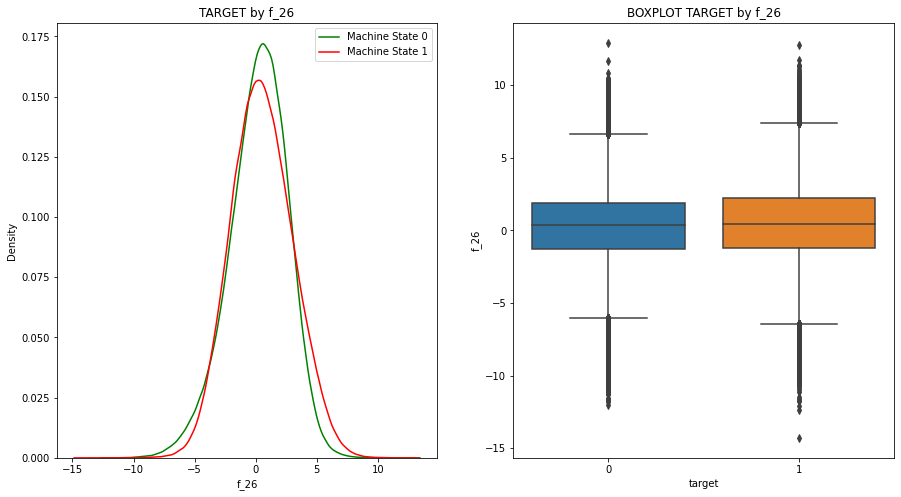

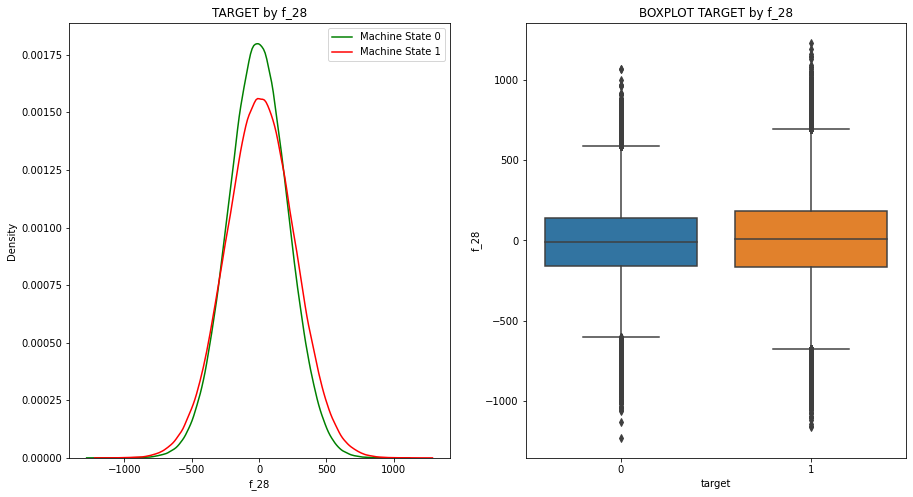

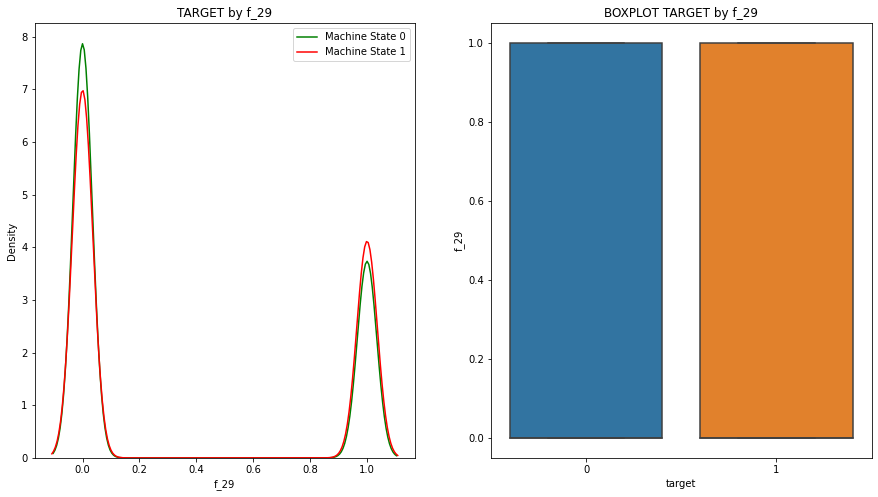

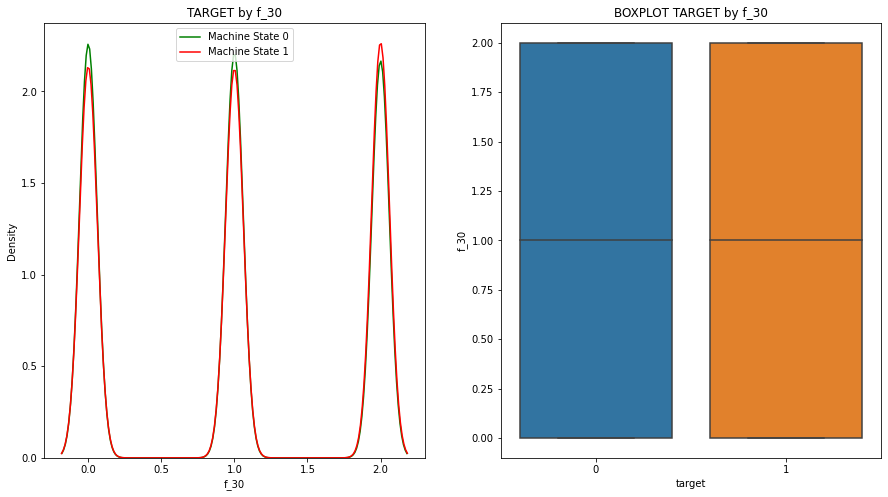

In [10]:
for col in numeric_cols[:-1]:
    numerical_plot(data,col)

## Feature Engineering

In [11]:
# Unique charachters count
data['unique_chars_cnt'] = data['f_27'].map(lambda x: len(set(x)))

# How often the text occurs in the whole dataset
data['value_frequency'] = data['f_27'].map(data['f_27'].value_counts() / len(data))

In [12]:
data.drop(['f_27'],axis=1,inplace=True)

data.drop(['id'],axis=1,inplace=True)

Correlation Matrix

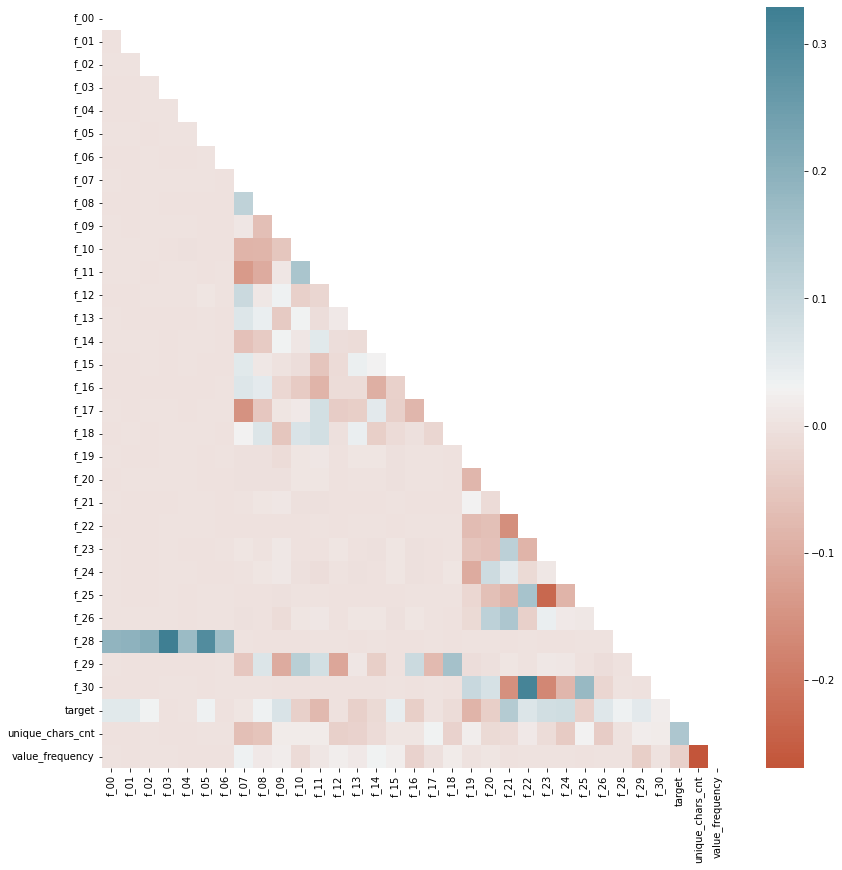

In [13]:
corr_plot(data, data.columns)

## Model Training

In [14]:
X_train = data.copy()
X_test = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/test.csv')
y_train = X_train.pop('target')
output= X_test.pop('id')

# Unique charachters count
X_test['unique_chars_cnt'] = X_test['f_27'].map(lambda x: len(set(x)))

# How often the text occurs in the whole dataset
X_test['value_frequency'] = X_test['f_27'].map(X_test['f_27'].value_counts() / len(X_test))

X_test.drop(['f_27'],axis=1,inplace=True)

#X_test.drop(['id'],axis=1,inplace=True)

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   f_00              900000 non-null  float64
 1   f_01              900000 non-null  float64
 2   f_02              900000 non-null  float64
 3   f_03              900000 non-null  float64
 4   f_04              900000 non-null  float64
 5   f_05              900000 non-null  float64
 6   f_06              900000 non-null  float64
 7   f_07              900000 non-null  int64  
 8   f_08              900000 non-null  int64  
 9   f_09              900000 non-null  int64  
 10  f_10              900000 non-null  int64  
 11  f_11              900000 non-null  int64  
 12  f_12              900000 non-null  int64  
 13  f_13              900000 non-null  int64  
 14  f_14              900000 non-null  int64  
 15  f_15              900000 non-null  int64  
 16  f_16              90

In [16]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
#rf = RandomForestClassifier(n_estimators=150,max_depth=18,random_state=100, oob_score=True)
#rf.fit(X_train, y_train)
#plot_roc_curve(rf, X_train, y_train)
#plt.show()

In [17]:
import xgboost as xgb
from sklearn import metrics
from sklearn import model_selection

xgb_model = xgb.XGBClassifier()

# Default-Run of default-hyperparameters
parameters = {'learning_rate': [0.1],
              'num_leaves': [180],
              'n_estimators': [350]}

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

clf_xgb = model_selection.GridSearchCV(estimator=xgb_model,
                                       param_grid=parameters,
                                       n_jobs=-1,
                                       cv=5,
                                       scoring=scorer,
                                       refit=True)

clf_xgb.fit(X_train, y_train)

rf = clf_xgb.best_estimator_

[09:57:27] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:57:27] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:57:27] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


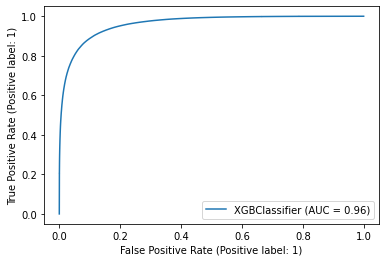

In [18]:
plot_roc_curve(rf, X_train, y_train)

In [19]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf.feature_importances_
})

In [20]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
30,unique_chars_cnt,0.095723
29,f_30,0.077028
28,f_29,0.053501
25,f_25,0.048813
14,f_14,0.047958
24,f_24,0.044678
7,f_07,0.041254
9,f_09,0.040519
19,f_19,0.038145
12,f_12,0.033919


## Model Prediction

In [21]:

predicted = rf.predict_proba(X_test)[:,1]



In [22]:
result = pd.DataFrame({"target": predicted}, index= output)
result.index.name = "id"
result.head()
result.to_csv("submission.csv", index=True)